In [4]:
import pandas as pd
fn = r'D:\bus2\ta_20250607132536.csv'
df = pd.read_csv(fn, skiprows=7, encoding='cp949')
df['날짜'] = df['날짜'].str.replace('\t', '', regex=False)
df['날짜'] = pd.to_datetime(df['날짜'])



In [ ]:
df['YYYY'] = df['날짜'].dt.year
df['MM'] = df['날짜'].dt.month
df['MMDD'] = df['날짜'].dt.strftime('%m-%d')

df = df[~df['MMDD'].isin(['02-29'])].copy()

year_size = df.groupby('YYYY').size()
print(year_size[year_size.values < 365 ])


YYYY
1907     92
1950    299
1951     31
1952    335
2025    157
dtype: int64


In [7]:
import numpy as np
df['t_roll'] = df['평균기온(℃)'].rolling(window=9, center=True).mean()
df['decade_group'] = np.floor((df['YYYY'] + 5) / 10).astype(int)

# 제거목록 191, 195, 203
data = df[~df['decade_group'].isin([191, 195, 203])][['decade_group','MM', 'MMDD', 't_roll']].groupby(['decade_group','MMDD']).mean('MMDD')
data.reset_index(inplace=True)

In [9]:
def str_to_datetime(year, df_series):
    return pd.to_datetime(str(year) + '-' + df_series, format='%Y-%m-%d')

winter_end_2000 =str_to_datetime(2000, data[(data['MM']<=4) & (data['t_roll'] < 5)]
                                 .groupby(['decade_group']).last()['MMDD']) 
winter_end_2001 = str_to_datetime(2001, data[(data['MM']<=4) & (data['t_roll'] < 5)]
                                  .groupby(['decade_group']).last()['MMDD'])

spring_end = str_to_datetime(2000, data[(data['MM']<=8) & (data['t_roll'] < 20)]
                             .groupby(['decade_group']).last()['MMDD'])

summer_end = str_to_datetime(2000, data[data['t_roll']>=20]
                             .groupby('decade_group').last()['MMDD'])

fall_end = str_to_datetime(2000, data[(data['MM'] >= 9) & (data['t_roll']>=5)]
                           .groupby('decade_group').last()['MMDD'])


In [ ]:
df_duration = pd.DataFrame({
    'spring': spring_end - winter_end_2000,
    'summer': summer_end - spring_end,
    'fall': fall_end - summer_end,
    'winter': winter_end_2001 - fall_end
})
df_duration.reset_index(inplace=True)

In [21]:
df_duration

,decade_group,spring,summer,fall,winter
0,192,74 days,97 days,58 days,136 days
1,193,77 days,100 days,64 days,124 days
2,194,79 days,98 days,68 days,120 days
3,196,83 days,102 days,65 days,115 days
4,197,77 days,104 days,58 days,126 days
5,198,77 days,114 days,60 days,114 days
6,199,78 days,110 days,65 days,112 days
7,200,81 days,115 days,66 days,103 days
8,201,73 days,122 days,65 days,105 days
9,202,81 days,129 days,54 days,101 days


Text(0, 0.5, 'days')

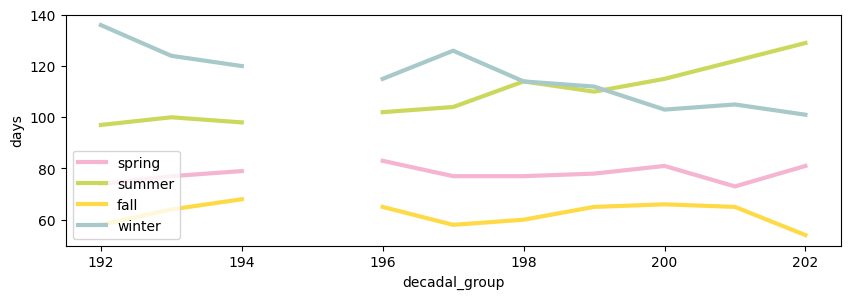

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot()
x = df_duration['decade_group']
colors = [
    (244/255, 180/255, 210/255),  # spring
    (203/255, 216/255, 91/255),   # summer
    (255/255, 218/255, 71/255),   # fall
    (167/255, 201/255, 201/255)   # winter
]

seasons = ['spring', 'summer', 'fall', 'winter']

for season, color in zip(seasons, colors):
    ax.plot(x[0:3], df_duration[season].dt.days[0:3], color=color, label=season, lw=3)
    ax.plot(x[3:], df_duration[season].dt.days[3:], color=color,  lw=3)
plt.legend(loc='lower left')
ax.set_xlabel('decadal_group')
ax.set_ylabel('days')